## 08.04.2019

## Part 1: File parsing

In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import datetime

In [2]:
file1 = './continuum_cal.fits'
file2 = './magnetogram_cal.fits'

In [3]:
fits.verify.warnings.simplefilter('ignore', category=fits.verify.VerifyWarning)

tmp = fits.open(file1)
data1 = tmp[0].data
data1 = np.flipud(data1)
tmp = fits.open(file2)
data2 = tmp[0].data
data2 = np.flipud(data2)

<b>Let's try to plot magnetogram:

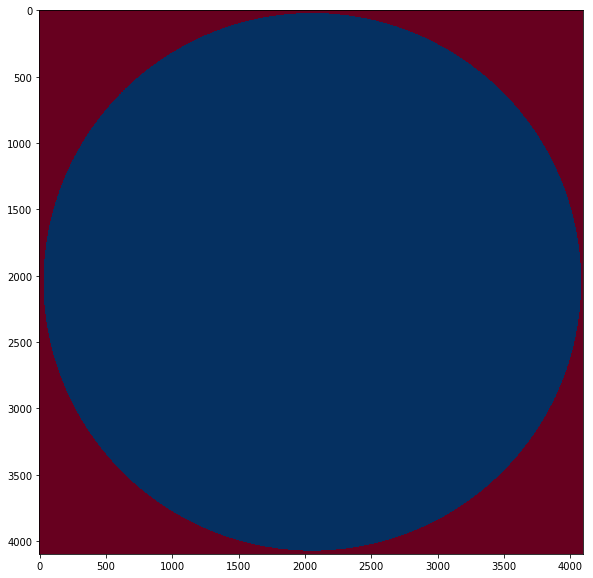

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(data2, 'RdBu')
plt.show()

On this plot you can see...nothing. The reason for this is a value of the background. Average value of the Sun region is zero. And values are in the limit from -5000 to 5000. So let's write a function, that will trim too large and too low values.

In [4]:
def mashtab (arr, maximum, minimum):
    ret = np.array(arr)
    ret[ret>maximum] = maximum
    ret[ret<minimum] = minimum
    return ret

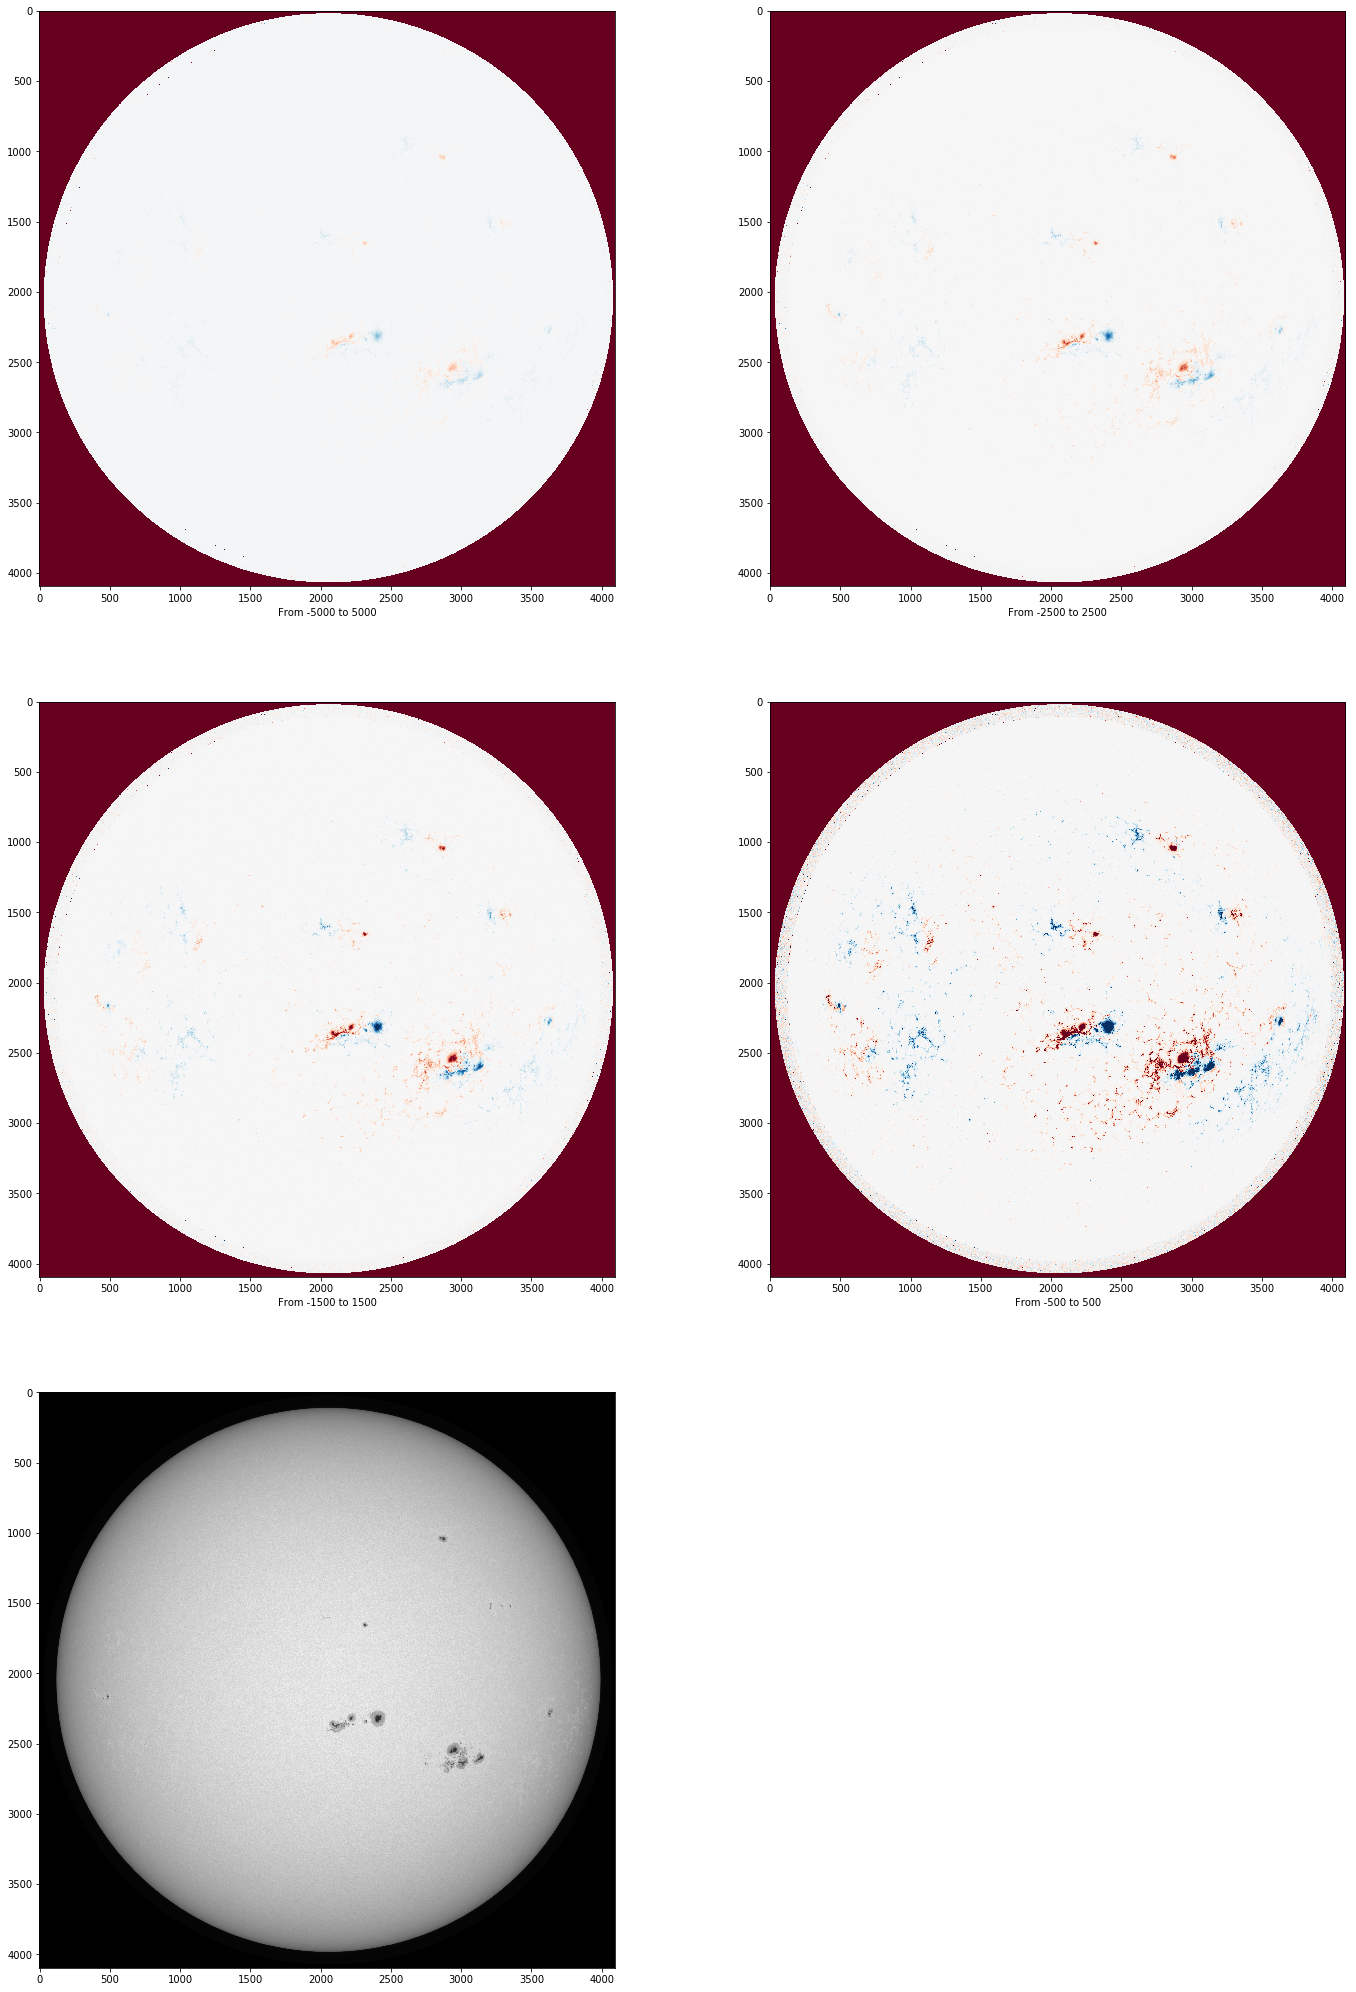

In [24]:
plt.figure(figsize=(24,36))
plt.subplot(3, 2, 1)
plt.xlabel('From -5000 to 5000')
plt.imshow(mashtab(data2, 5000, -5000), 'RdBu')
plt.subplot(3, 2, 2)
plt.xlabel('From -2500 to 2500')
plt.imshow(mashtab(data2, 2500, -2500), 'RdBu')
plt.subplot(3, 2, 3)
plt.xlabel('From -1500 to 1500')
plt.imshow(mashtab(data2, 1500, -1500), 'RdBu')
plt.subplot(3, 2, 4)
plt.xlabel('From -500 to 500')
plt.imshow(mashtab(data2, 500, -500), 'RdBu')
plt.subplot(3, 2, 5)
plt.imshow(data1, 'gray')
plt.show()

Now it looks much better! On these pictures we can notice that north and south poles are usually located nearby.

## Part 2. Histograms

<b> Now let's plot a histogram of the Sun's magnet field:

In [6]:
allSunHist = []
gag = data2.flatten()
for i in gag:
    if i>-5000:
        allSunHist.append(i)

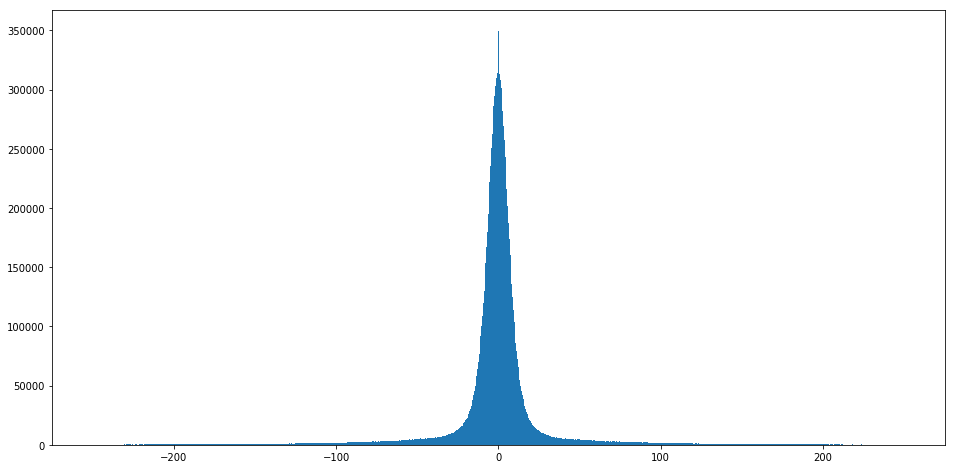

In [7]:
plt.figure(figsize=(16,8))
plt.hist(allSunHist, 1000, range = (-250, 250))
plt.show()

As we can see, average value is 0, and most of values are in the limit from -30 to 30.

<b> Now let's check spots:

In [25]:
spotM = data2[2200:2500,2000:2500]
spotP = data1[2200:2500,2000:2500]

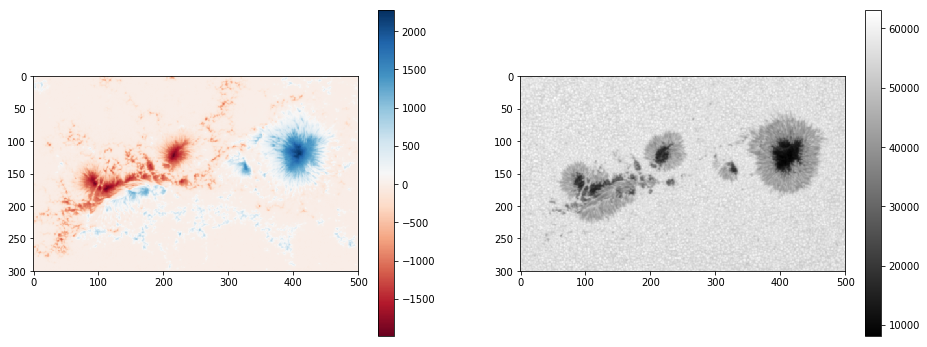

In [9]:
plt.figure(figsize=(16,12))
plt.subplot(1, 2, 1)
plt.imshow(spotM, 'RdBu')
plt.colorbar(shrink=0.5)
plt.subplot(1, 2, 2)
plt.imshow(spotP, 'gray')
plt.colorbar(shrink=0.5)
plt.show()

<b> Zoom in!

In [10]:
spot2M = data2[2250:2390,2340:2480]
spot2P = data1[2250:2390,2340:2480]
spotHist = data2[2250:2390,2340:2480].flatten()
grSpotHist = data1[2250:2390,2340:2480].flatten()

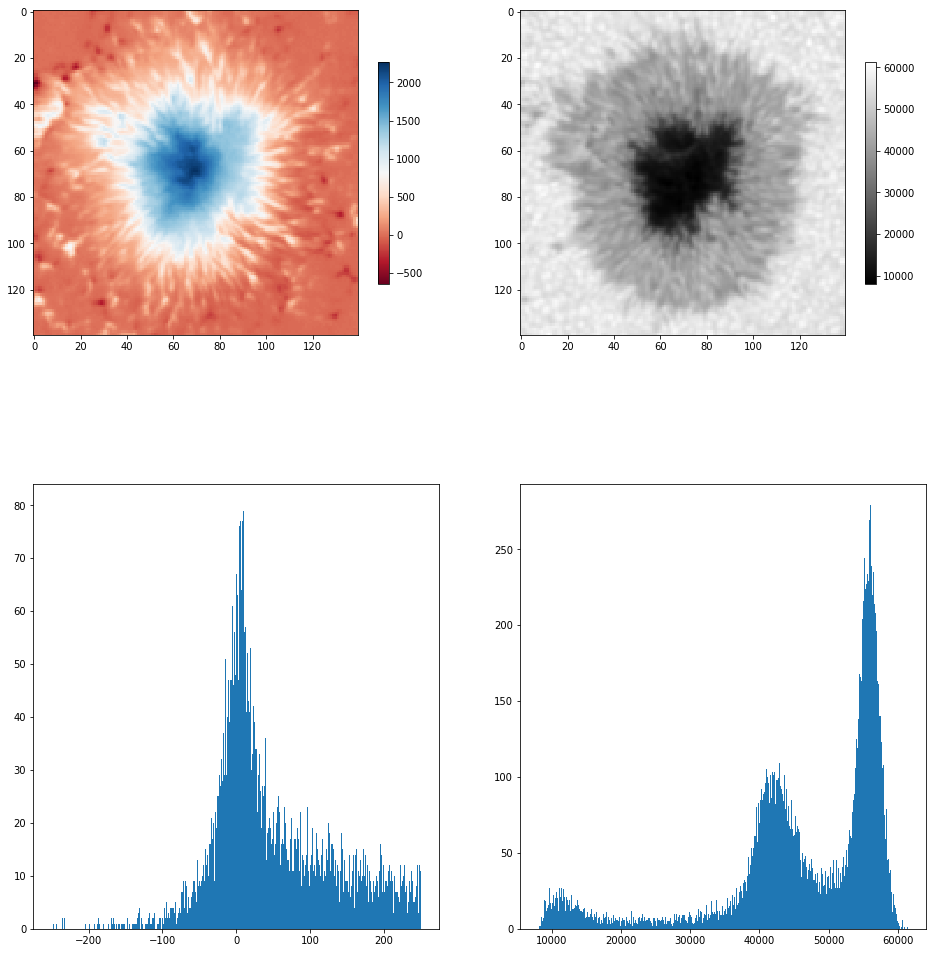

In [11]:
plt.figure(figsize=(16,18))
plt.subplot(2, 2, 1)
plt.imshow(spot2M, 'RdBu')
plt.colorbar(shrink=0.5)
plt.subplot(2, 2, 2)
plt.imshow(spot2P, 'gray')
plt.colorbar(shrink=0.5)
plt.subplot(2, 2, 3)
plt.hist(spotHist, 1000, range = (-250, 250))
plt.subplot(2, 2, 4)
plt.hist(grSpotHist, 500)

plt.show()

<b> On the second image and histogram we can see, that umbra's value less than ~25000, and penumbra values belong to the interval from ~25000 to ~50000. Let's find contours of umbra and penumbra using this values and draw these contours on the first (magnetogram) picture:

In [12]:
trsh = spot2P.copy()

In [13]:
trsh[trsh>50000] = 50000
trsh[trsh<25000] = 50000
trsh[trsh<50000] = 0
trsh[trsh>0] = 250
trsh = trsh.astype('uint8')

In [14]:
contours, hierarch = cv2.findContours(trsh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
realcont=[] #0 - penumbra, 1 - umbra
for cont in contours:
    M = cv2.moments(cont)
    if M['m00']>20 and M['m00']<19000:
        realcont.append(cont)

In [15]:
contSpotM = cv2.cvtColor(np.round((spot2M+650)/12).astype('uint8'), cv2.COLOR_GRAY2BGR)
contSpotP = cv2.cvtColor(np.round((spot2P)/245).astype('uint8'), cv2.COLOR_GRAY2BGR)
contSpotM = cv2.drawContours(contSpotM, realcont, -1, (0, 0, 255),1)
contSpotP = cv2.drawContours(contSpotP, realcont, -1, (0, 0, 255),1)
contSpotM = cv2.cvtColor(contSpotM, cv2.COLOR_BGR2RGB)
contSpotP = cv2.cvtColor(contSpotP, cv2.COLOR_BGR2RGB)

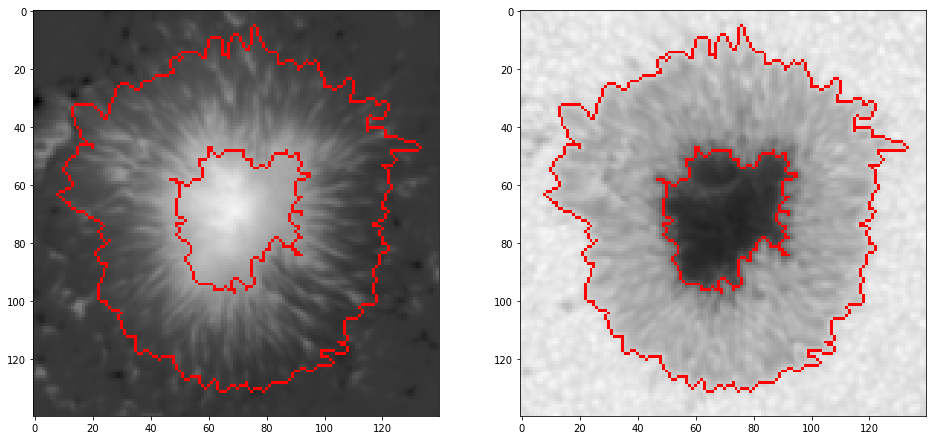

In [16]:
plt.figure(figsize=(16,12))
plt.subplot(1, 2, 1)
plt.imshow(contSpotM)
plt.subplot(1, 2, 2)
plt.imshow(contSpotP)
plt.show()

<b> Done! Now let's find mean magnetic flux density of umbra, penumbra and quiet Sun. We don't know the unit, that is used in this picture, so let's use a "parrot" unit of measure equal to the value divided by the area (in pixels).

In [17]:
UmbraCoordinates = []
PenumbraCoordinates = []
umbramgn = 0
penumbramgn = 0

for rows in range(spot2M.shape[0]+1):
    for columns in range(spot2M.shape[1]+1):
        if (cv2.pointPolygonTest(realcont[1], (rows,columns), measureDist = False)) == 1:
            UmbraCoordinates.append([rows, columns])
            umbramgn+=spot2M[rows, columns]
        elif(cv2.pointPolygonTest(realcont[0], (rows,columns), measureDist = False)) == 1:
            PenumbraCoordinates.append([rows,columns]) 
            penumbramgn+=spot2M[rows, columns]

In [18]:
print 'Umbra mean magnetic flux density', round(umbramgn/len(UmbraCoordinates), 2), 'parrots'
print 'Penumbra mean magnetic flux density', round(penumbramgn/len(PenumbraCoordinates), 2), 'parrots'
print 'Quiet Sun mean magnetic flux density', round(np.average(data2[1000:1200, 1000:1200]), 2), 'parrots'

Umbra mean magnetic flux density 1615.44 parrots
Penumbra mean magnetic flux density 493.58 parrots
Quiet Sun mean magnetic flux density -0.7 parrots


### Now let's compare the size of the sunspot with the size of the Earth:
(Comments are in the code)

In [26]:
k = data2[4096/2, :]
lft = 0
rght = 0
for i in range(len(k)):
    if k[i]>-0.5:
        lft = i
        break
for i in range(len(k)-1, 0, -1):
    if k[i]>-0.5:
        rght =  i
        break
diam = rght - lft #diameter of the Sun [pixels]

In [20]:
sunD = 1391000000 #diameter of the Sun[m]
earthD = 12742000 #diameter of the Earth[m]
earthPixRad = earthD / (sunD / diam) / 2 # radius of the Earth [pixels]

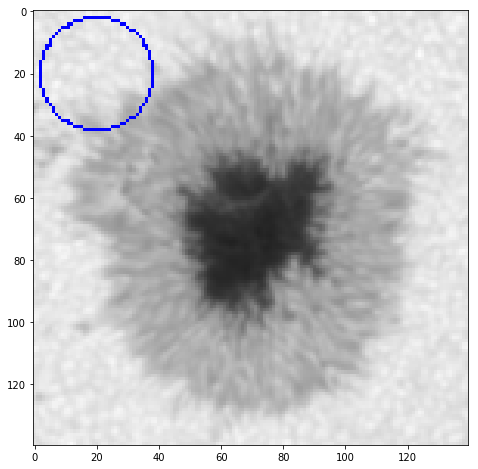

In [21]:
plt.figure(figsize=(8, 8))
plt.imshow(cv2.circle(cv2.cvtColor(np.round((spot2P)/245).astype('uint8'), cv2.COLOR_GRAY2BGR), (20,20), earthPixRad, (0, 0, 255),1, 7, 0))
plt.show()

Little blue circle is the Earth =)